## Autoencoders




In this lab, we are going to review the concept of autoencoders, and build a few examples of them! :D

Autoencoders are neural networks trained to attempt to copy their input to their output. They should contain an enconding function, a decoding function and a loss function to compare the difference between the input and the output during the learning process. 

They use the encoder to compress the input into a lower dimensional code, and then reconstruct the output again from this code using the encoder. This compression and decompression process is always data-specific, because they learn features exclusively from the data they were trained on, so they can't generalize very well with other types of data that they haven't seen before. They are also lossy. They can't reconstruct the input perfectly, but instead, a close representation of the original input. Another interesting property of the autoencoders it that they don't need the input data to be labeled, they can generate their own labels just from raw data, and that makes it a self-supervised algorithm.

### Architecture

Like mentionated above, you need an encoder, a code and a decoder. You can build this architecture in a lot of different ways. A simple example would envolve fully connected layers for both the encoder and the decoder, mirroring each other, and a smaller layer in the middle of them, which is the code.

Using TensorFlow backend.


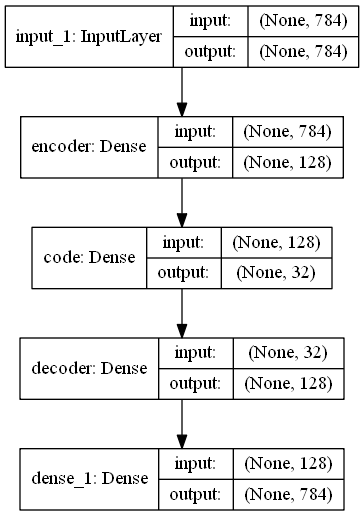

In [1]:
# Let's build the architecture describe above:

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

import numpy as np

input_size = 784
hidden_size = 128
code_size = 32

# This is the encoder. Here, our inputs are compressed into the code
input = Input(shape=(input_size,))
encoder = Dense(hidden_size, activation='relu', name='encoder')(input)

# Here is our code. The lower it's size, the more compressed our output will be
code = Dense(code_size, activation='relu', name='code')(encoder)

# This is the decoder. It gets the input from the code, and tries to rebuild the original input. Notice that the the number of nodes in this layer is the same size as
# our encoder layer ( they mirror each other), and the output has the same size as the input.
decoder = Dense(hidden_size, activation='relu', name='decoder')(code)
output = Dense(input_size, activation='sigmoid')(decoder)

# Here is the labeling process. Our model is using the output from the decoder as the labels for out input data
autoencoder = Model(input, output)

# Plot the architecture
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

### Training and testing our model

Now that we have our architecture ready, let's load the MNIST dataset and see it in action!

In [2]:
# Let's load the MNIST dataset so we can show the autoencoder in action.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# This is important. We normally use x_train, y_train, but here the targets of the autoencoder are the same as the inputs, that's why we are using x_train, x_train here.
autoencoder.fit(x_train, x_train, epochs=1)

Epoch 1/1
60000/60000 [==============================] - 10s 161us/step - loss: 0.1367


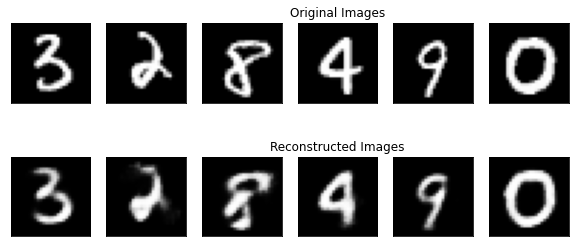

In [3]:
def display_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)
    
    # number of example digits to show
    n = 6    
    # select a random image from the mnist dataset
    random_matrix = np.random.randint(6000, size = n)

    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[random_matrix[i]].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[random_matrix[i]].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()
    

display_outputs(autoencoder, 5, (28, 28))

Above we can see the autoencoder in action by using the keras predict function. We can see that the reconstructed images are similar to the original ones, but not exactly equal. The results so far are looking good, but we do have some control over the architecture, and since we are dealing with images in this example, maybe we should build a convolutional autoencoder?

### Convolutional autoencoder architecture

Convolutional networks usually have a better performance when dealing with images, so using a convolutional architecture for our autoencoder makes sense when working with an image dataset. We can explore the properties of the MaxPooling layer in the encoder, because it works exactly as we need by reducing the size of our input, and then, when pass the reduced image to the decoder, we use the UpSampling layer to increase the size once again and build our output.

In [4]:
input_img = Input(shape=(28, 28, 1))

encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoded = MaxPooling2D((2, 2), padding='same')(encoder)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

decoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(16, (3, 3), activation='relu')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

## Preparating the mnist dataset once again
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 137us/step - loss: 0.2072 - val_loss: 0.1592
Epoch 2/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.1501 - val_loss: 0.1457
Epoch 3/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.1369 - val_loss: 0.1304
Epoch 4/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.1301 - val_loss: 0.1272
Epoch 5/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.1259 - val_loss: 0.1232
Epoch 6/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.1228 - val_loss: 0.1239
Epoch 7/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.1203 - val_loss: 0.1198
Epoch 8/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.1179 - val_loss: 0.1159
Epoch 9/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.1161 - val_loss: 0.1

### Testing our new model

It's time to see the results of our new architecture. You are encouraged to actually create your own models and see how they will perform :)

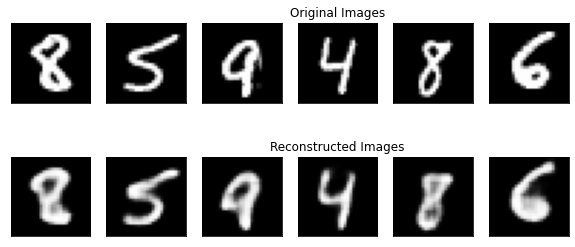

In [5]:
display_outputs(autoencoder, 5, (28, 28))